# Univariate timeseries and exogenous effects

In [1]:
# Disable warnings
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sktime.transformations.series.fourier import FourierFeatures
from sktime.forecasting.compose import ForecastingPipeline
from numpyro import distributions as dist
import numpyro
numpyro.enable_x64()

# Import dataset

We import a dataset from Prophet's original repository. We then put it into sktime-friendly format, where the index is a `pd.PeriodIndex` and the colums are the time series.

In [2]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df["ds"] = pd.to_datetime(df["ds"]).dt.to_period("D")
y = df.set_index("ds")
display(y)

,y
ds,
2007-12-10,9.590761
2007-12-11,8.519590
2007-12-12,8.183677
2007-12-13,8.072467
2007-12-14,7.893572
...,...
2016-01-16,7.817223
2016-01-17,9.273878
2016-01-18,10.333775


<Axes: xlabel='ds'>

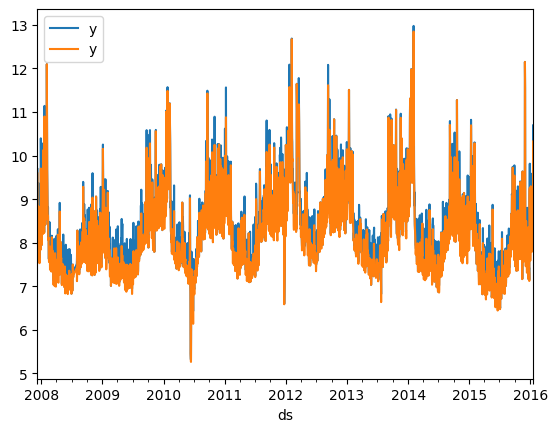

In [3]:
y2 = y.copy()
# Set numpy seed
np.random.seed(0)

# Create random input
X = pd.DataFrame(
    np.abs(np.random.rand(len(y2), 1))**4,
    index=y2.index,
    columns=["exog"],
)
true_exog_effect = np.log(1.5 * X["exog"].values.reshape((-1, 1)) + 1) * 0.8
y2 = y + true_exog_effect
ax = y2.plot.line()
y.plot.line(ax=ax)

In [4]:
mocked_lift_test_experiment = pd.DataFrame(data=np.random.normal(true_exog_effect,0.1), columns=["lift_results"], index=y2.index)

## Custom effect

In the last example, we used an effect that was imported from Prophetverse. You may, however, be interested in your own effects. Lets create a custom "Hill" effect, that is used in Marketing Mix Modelling applications.

In [5]:
from prophetverse.effects.base import BaseEffect
import jax.numpy as jnp
class HillEffect(BaseEffect):
    """
    Represents a Hill effect in a time series model.

    Attributes:
        half_max_prior: Prior distribution for the half-maximum parameter.
        slope_prior: Prior distribution for the slope parameter.
        max_effect_prior: Prior distribution for the maximum effect parameter.
        effect_mode: Mode of the effect (either "additive" or "multiplicative").
    """

    def __init__(
        self,
        half_max_prior=None,
        slope_prior=None,
        max_effect_prior=None,
        min_slope=0,
        effect_mode="multiplicative",
        **kwargs
    ):
        
        if half_max_prior is None:
            half_max_prior = dist.Gamma(2, 1)
        if slope_prior is None:
            slope_prior = dist.HalfNormal(2)
        if max_effect_prior is None:
            max_effect_prior = dist.Gamma(2, 1)
            
        self.half_max_prior = half_max_prior
        self.slope_prior = slope_prior
        self.min_slope = min_slope
        self.max_effect_prior = max_effect_prior
        self.effect_mode = effect_mode
        super().__init__(**kwargs)

    def _apply(self, trend, data):
        """
        Computes the effect using the log transformation.

        Args:
            trend: The trend component.
            data: The input data.

        Returns:
            The computed effect.
        """

        half_max = self.sample("half_max", self.half_max_prior)
        slope = self.sample("slope", self.slope_prior) + self.min_slope
        max_effect = self.sample("max_effect", self.max_effect_prior)

        effect = max_effect * (1 / (1 + (data/half_max)**-slope))
        effect = jnp.clip(effect, 0, max_effect)
        if self.effect_mode == "additive":
            return effect
        return trend * effect

In [6]:
from prophetverse.effects.log import LogEffect
import numpyro
from prophetverse.sktime import Prophetverse
from prophetverse.sktime.seasonality import seasonal_transformer
from prophetverse.effects.linear import LinearEffect
from prophetverse.utils.regex import starts_with
from prophetverse.effects.compose import LiftExperimentLikelihood


exogenous_effects = [
    LinearEffect(
        prior=dist.Normal(0, 0.1),
        effect_mode="multiplicative",
        id="seasonality",
        regex=starts_with(["sin", "cos"]),
    ),
    LiftExperimentLikelihood(
        effect=HillEffect(
            effect_mode="additive",
            id="exog",
            regex=starts_with("exog"),
        ),
        lift_test_results=mocked_lift_test_experiment,
        prior_scale=.05,
    ),
]

model = Prophetverse(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    feature_transformer=seasonal_transformer(
        freq="D", yearly_seasonality=True, weekly_seasonality=True
    ),
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=50000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model.fit(y=y2, X=X)

100%|██████████| 50000/50000 [00:10<00:00, 4769.74it/s, init loss: 4153.8517, avg. loss [47501-50000]: -11136.2065]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[LinearEffect(id='seasonality',
                                             prior=<numpyro.distributions.continuous.Normal object at 0x30a8e6610>,
                                             regex='^(?:sin|cos)'),
                                LiftExperimentLikelihood(effect=HillEffect(effect_mode='additive',
                                                                           half_max_prior=<numpyro.distributions.continuous.Gamma object at 0x30aba4f10>,
                                                                           ma...
2007-12-13      0.081087
2007-12-14      0.120593
...                  ...
2016-01-16     -0.135488
2016-01-17     -0.134987
2016-01-18      0.181435
2016-01-19      0.273608
2016-01-20      0.564896

[2905 rows x 1 columns],
                                                         prior_scale=0.05)],
             feature_transformer=FourierFeatures(fourier_terms_list=[10, 3],
                                                 freq='D',
                                                 keep_original_columns=True,
                                                 sp_list=['Y', 'W']),
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=50000)

In [7]:
exogenous_effects = [
    LinearEffect(
        prior=dist.Normal(0, 0.1),
        effect_mode="multiplicative",
        id="seasonality",
        regex=starts_with(["sin", "cos"]),
    ),
    HillEffect(
            effect_mode="additive",
            id="exog",
            regex=starts_with("exog"),
        )
]

model_wo_lift = Prophetverse(
    trend="linear",
    changepoint_interval=300,
    changepoint_prior_scale=0.0001,
    feature_transformer=seasonal_transformer(
        freq="D", yearly_seasonality=True, weekly_seasonality=True
    ),
    exogenous_effects=exogenous_effects,
    noise_scale=0.05,
    optimizer_steps=50000,
    optimizer_name="Adam",
    optimizer_kwargs={"step_size": 0.0001},
    inference_method="map",
)
model_wo_lift.fit(y=y2, X=X)

100%|██████████| 50000/50000 [00:10<00:00, 4923.64it/s, init loss: 7623.7989, avg. loss [47501-50000]: -4975.8716]


Prophetverse(changepoint_interval=300, changepoint_prior_scale=0.0001,
             exogenous_effects=[LinearEffect(id='seasonality',
                                             prior=<numpyro.distributions.continuous.Normal object at 0x30abd1810>,
                                             regex='^(?:sin|cos)'),
                                HillEffect(effect_mode='additive',
                                           half_max_prior=<numpyro.distributions.continuous.Gamma object at 0x30abf9510>,
                                           max_effect_prior=<numpyro.distributions.continuous.Gamma object at 0x30abf9a90>,
                                           slope_prior=<numpyro.distributions.continuous.HalfNormal object at 0x30abf99d0>)],
             feature_transformer=FourierFeatures(fourier_terms_list=[10, 3],
                                                 freq='D',
                                                 keep_original_columns=True,
                                                 sp_list=['Y', 'W']),
             optimizer_kwargs={'step_size': 0.0001}, optimizer_steps=50000)

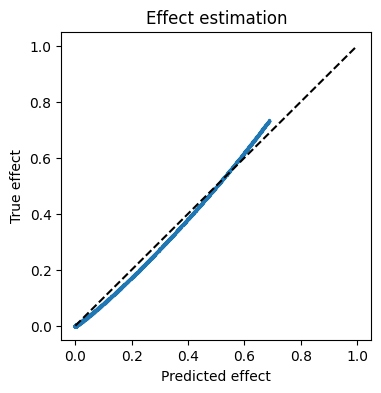

In [8]:
sites = model.predict_all_sites(fh=X.index, X=X)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(sites["exog"], true_exog_effect, s=2)
# 45 degree line
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Predicted effect")
ax.set_ylabel("True effect")
ax.set_title("Effect estimation")
fig.show()

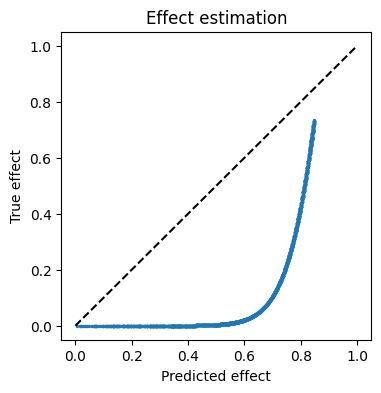

In [9]:
sites_wo_lift = model_wo_lift.predict_all_sites(fh=X.index, X=X)

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(sites_wo_lift["exog"], true_exog_effect, s=2)
# 45 degree line
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("Predicted effect")
ax.set_ylabel("True effect")
ax.set_title("Effect estimation")
fig.show()

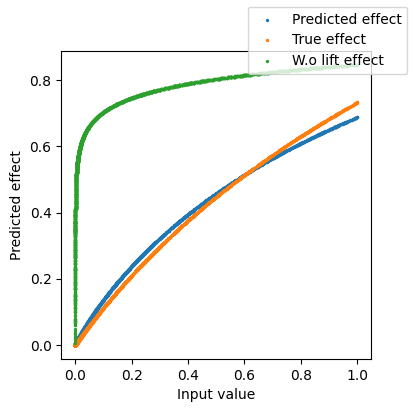

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X["exog"], sites["exog"], s=2, label="Predicted effect")
ax.scatter(X["exog"], true_exog_effect, s=2, label="True effect")
ax.scatter(X["exog"], sites_wo_lift["exog"], s=2, label="W.o lift effect")
ax.set_xlabel("Input value")
ax.set_ylabel("Predicted effect")
fig.legend()
fig.show()